# Библиотеки

In [1]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    !git clone -qq https://github.com/kbayazitov/distillation.git /tmp/repo
    !python3 -m pip install -qq /tmp/repo/src/ && rm -rf /tmp/repo

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import torch
from torchvision import datasets, transforms

In [3]:
from pylab import rcParams

rcParams['figure.figsize'] = (20.0, 10.0)
rcParams['legend.fontsize'] = 20
rcParams['axes.titlesize']=20
rcParams['axes.labelsize']=20
rcParams['font.size'] = 20
rcParams['lines.linewidth'] = 3
rcParams['axes.formatter.use_locale'] = True

In [4]:
from mylib.train import label_to_digit, Perceptron, TeacherModel, train_teacher, distillation_train,\
                         trainer, VAE, draw_samples_grid_vae, fmnist_to_mnist, fmnist_to_fmnist,\
                         GeneratedMNIST, add_noise, dilation, makeplots

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Данные

In [7]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())
MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

In [8]:
FMNIST_train = datasets.FashionMNIST('./fmnist', train=True, download=True, 
                             transform=transforms.ToTensor())

FMNIST_test = datasets.FashionMNIST('./fmnist', train=False, download=True,
                            transform=transforms.ToTensor())

In [9]:
fmnist_big, fmnist_small = torch.utils.data.random_split(FMNIST_train, [59000, 1000], generator=torch.Generator().manual_seed(42))

In [10]:
mnist_big, mnist_small = torch.utils.data.random_split(MNIST_train, [59000, 1000], generator=torch.Generator().manual_seed(42))

In [33]:
FashionDigit = torch.utils.data.TensorDataset(FMNIST_train.data/255,
                                              label_to_digit(MNIST_train, FMNIST_train.targets))

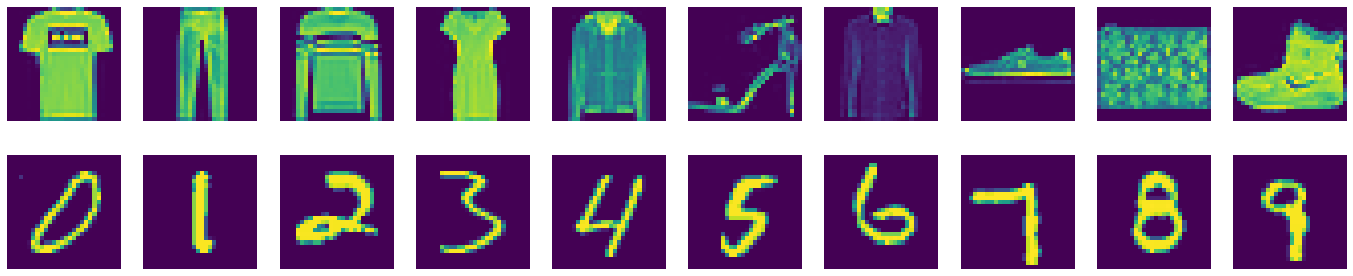

In [34]:
indices = [1,16,5,20,28,8,33,14,23,0]

fmnist_images = []
for i in indices:
    fmnist_images.append(FashionDigit[i][0])

mnist_images = []
for i in indices:
    mnist_images.append(FashionDigit[i][1])   

fig, gs = plt.figure(figsize=(24,5)), gridspec.GridSpec(2, 10)

ax = []

for i in range(10):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(fmnist_images[i].view([28,28])))
    ax[i].axis('off')

for i in range(10):
    ax.append(fig.add_subplot(gs[i+10]))
    ax[i+10].imshow(np.array(mnist_images[i].cpu()))
    ax[i+10].axis('off')

plt.show()

# Обучение на всей выборке

In [ ]:
Student = Perceptron(num_layers=1, hidden_dim=64)
Student.to(device)
_ = Student.train()
list_of_test_acc, list_of_test_losses, _, _ = distillation_train(Student, FMNIST_train, FMNIST_test)

In [ ]:
Teacher = Perceptron(num_layers=4, hidden_dim=500)
Teacher.to(device)
_ = Teacher.train()
train_teacher(Teacher, FMNIST_train, FMNIST_test)

In [ ]:
Student = Perceptron(num_layers=1, hidden_dim=64)
Student.to(device)
_ = Student.train()
list_of_test_acc_dist, list_of_test_losses_dist, _, _ =\
                        distillation_train(Student, FMNIST_train, FMNIST_test, teacher=Teacher)

In [ ]:
labels = ['Без учителя', 'С учителем']

makeplot_acc([list_of_test_acc, list_of_test_acc_dist], labels)
makeplot_loss([list_of_test_losses, list_of_test_losses_dist], labels)

In [ ]:
print('Accuracy of student without teacher on all dataset={}+-{}'.format(round(np.array(list_of_test_acc).mean(0)[-1], 3),
                                                          round(np.array(list_of_test_acc).std(0)[-1],3)))
print('Loss of student without teacher on all dataset={}+-{}'.format(round(np.array(list_of_test_losses).mean(0)[-1], 3),
                                                      round(np.array(list_of_test_losses).std(0)[-1],3)))
print('Accuracy of student with teacher on all dataset={}+-{}'.format(round(np.array(list_of_test_acc_dist).mean(0)[-1],3),
                                                       round(np.array(list_of_test_acc_dist).std(0)[-1],3)))
print('Loss of student with teacher on all dataset={}+-{}'.format(round(np.array(list_of_test_losses_dist).mean(0)[-1],3),
                                                   round(np.array(list_of_test_losses_dist).std(0)[-1],3)))

# Обучение ученика и учителя на малоресурсной выборке

In [ ]:
Student = Perceptron(num_layers=1)
Student.to(device)
_ = Student.train()
list_of_test_acc, list_of_test_losses, _, _= distillation_train(Student, fmnist_small, FMNIST_test)

In [ ]:
Teacher = TeacherModel()
Teacher.to(device)
_ = Teacher.train()
train_teacher(Teacher, fmnist_big, FMNIST_test)

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Student.to(device)
_ = Student.train()
list_of_test_acc_dist, list_of_test_losses_dist, _, _ =\
                        distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher)

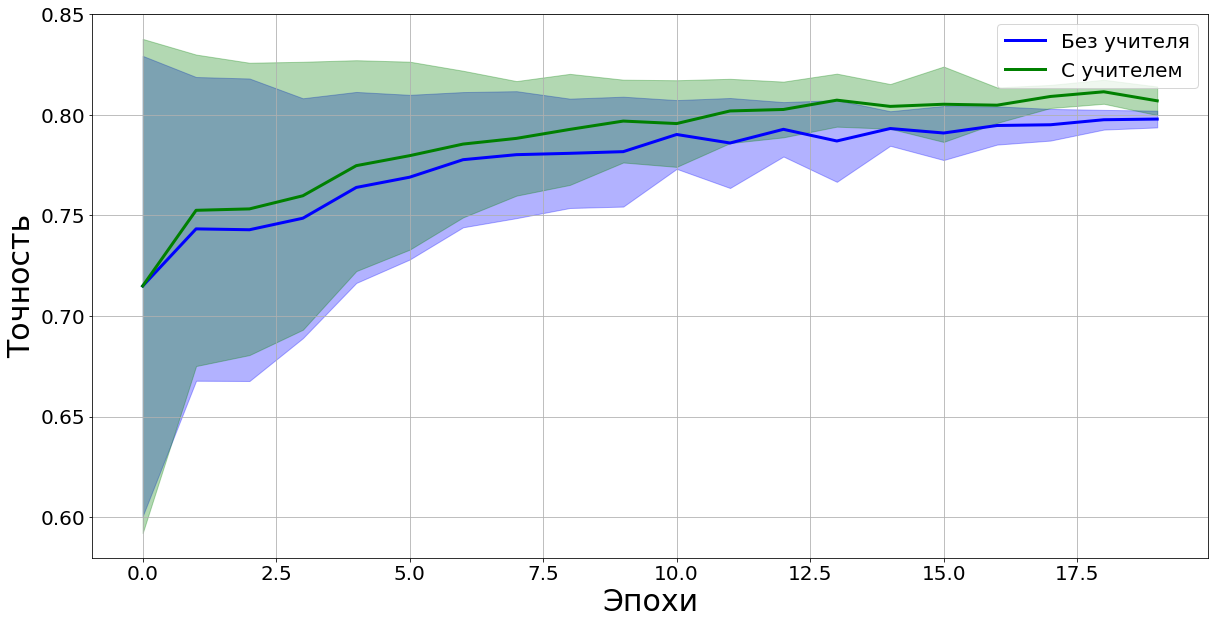

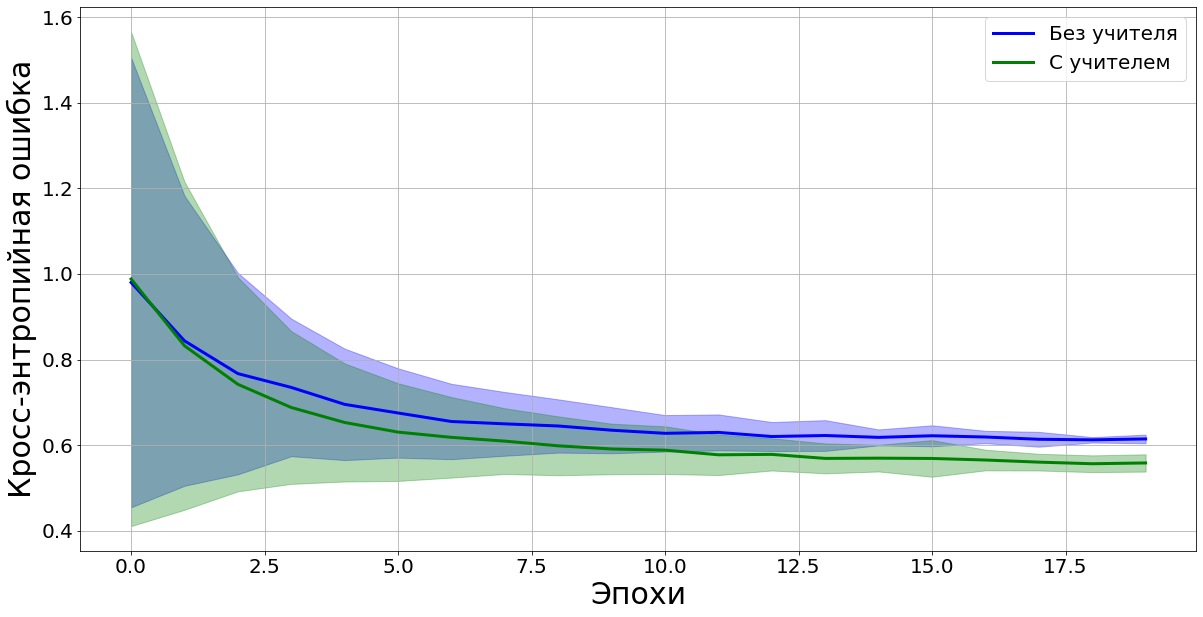

In [15]:
labels = ['Без учителя', 'С учителем']
makeplots([list_of_test_acc, list_of_test_acc_dist],
          [list_of_test_losses, list_of_test_losses_dist],
          labels)

In [17]:
print('Accuracy of student without teacher={}+-{}'.format(round(np.array(list_of_test_acc).mean(0)[-1], 3),
                                                          round(np.array(list_of_test_acc).std(0)[-1],3)))
print('Loss of student without teacher={}+-{}'.format(round(np.array(list_of_test_losses).mean(0)[-1], 3),
                                                      round(np.array(list_of_test_losses).std(0)[-1],3)))
print('Accuracy of student with teacher={}+-{}'.format(round(np.array(list_of_test_acc_dist).mean(0)[-1],3),
                                                       round(np.array(list_of_test_acc_dist).std(0)[-1],3)))
print('Loss of student with teacher={}+-{}'.format(round(np.array(list_of_test_losses_dist).mean(0)[-1],3),
                                                   round(np.array(list_of_test_losses_dist).std(0)[-1],3)))

Accuracy of student without teacher=0.798+-0.004
Loss of student without teacher=0.615+-0.01
Accuracy of student with teacher=0.807+-0.007
Loss of student with teacher=0.559+-0.02


# Обучение на выборке с шумом

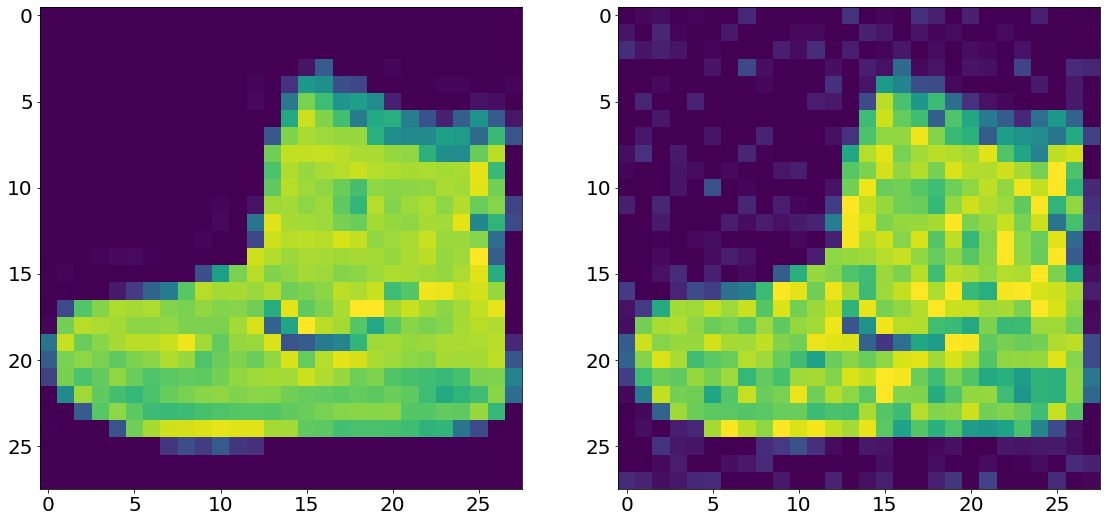

In [18]:
image = FMNIST_train[0][0][0]
noise_image = add_noise(image)

fig, gs = plt.figure(figsize=(19,10)), gridspec.GridSpec(1, 2)

images = [image, noise_image]

ax = []

for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(images[i]))

plt.show()

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = TeacherModel().to(device)

_ = Teacher.train()
train_teacher(Teacher, fmnist_big, FMNIST_test, phi=lambda x: add_noise(x))

_ = Student.train()
list_of_test_acc_noise, list_of_test_losses_noise, _, _ =\
                        distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher, phi=lambda x: add_noise(x))

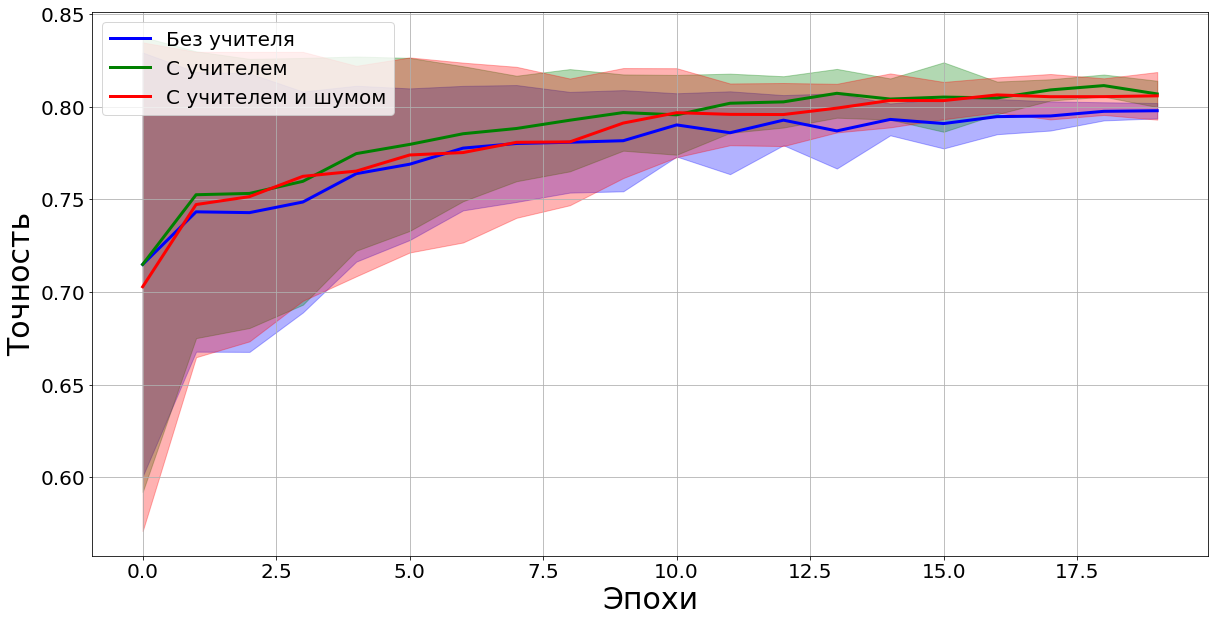

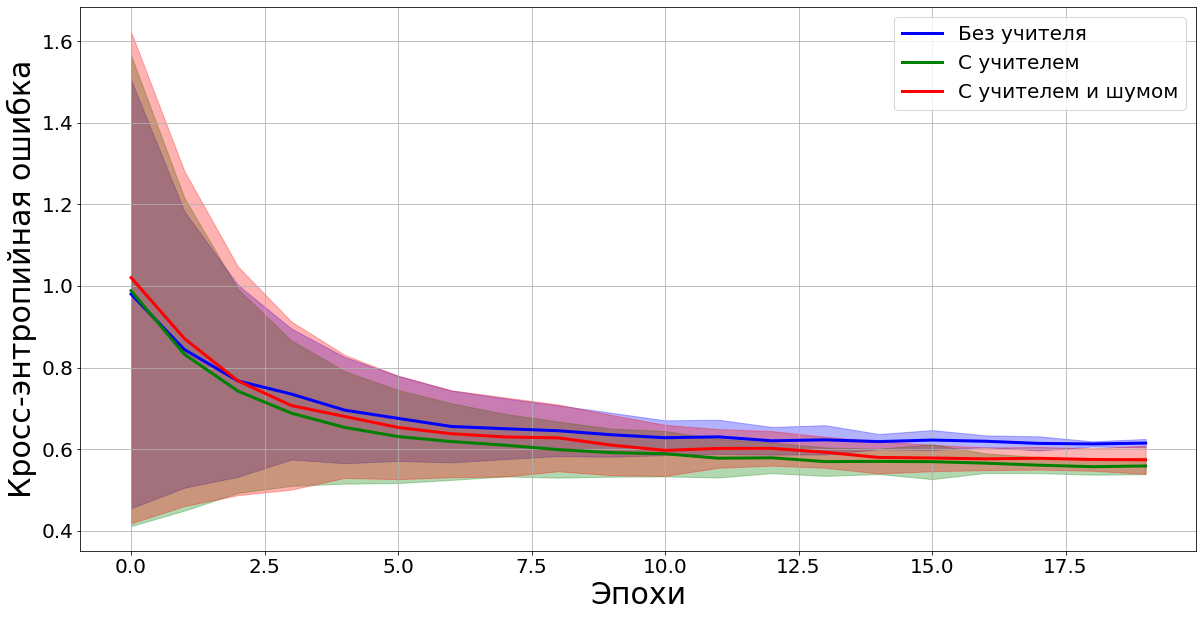

In [23]:
labels = ['Без учителя', 'С учителем', 'С учителем и шумом']

makeplots([list_of_test_acc, list_of_test_acc_dist, list_of_test_acc_noise],
          [list_of_test_losses, list_of_test_losses_dist, list_of_test_losses_noise],
          labels)

In [24]:
print('Accuracy of student with noise teacher={}+-{}'.format(round(np.array(list_of_test_acc_noise).mean(0)[-1],3),
                                                       round(np.array(list_of_test_acc_noise).std(0)[-1],3)))
print('Loss of student with noise teacher={}+-{}'.format(round(np.array(list_of_test_losses_noise).mean(0)[-1],3),
                                                   round(np.array(list_of_test_losses_noise).std(0)[-1],3)))

Accuracy of student with noise teacher=0.806+-0.013
Loss of student with noise teacher=0.574+-0.035


# Обучение на выборке с dilation

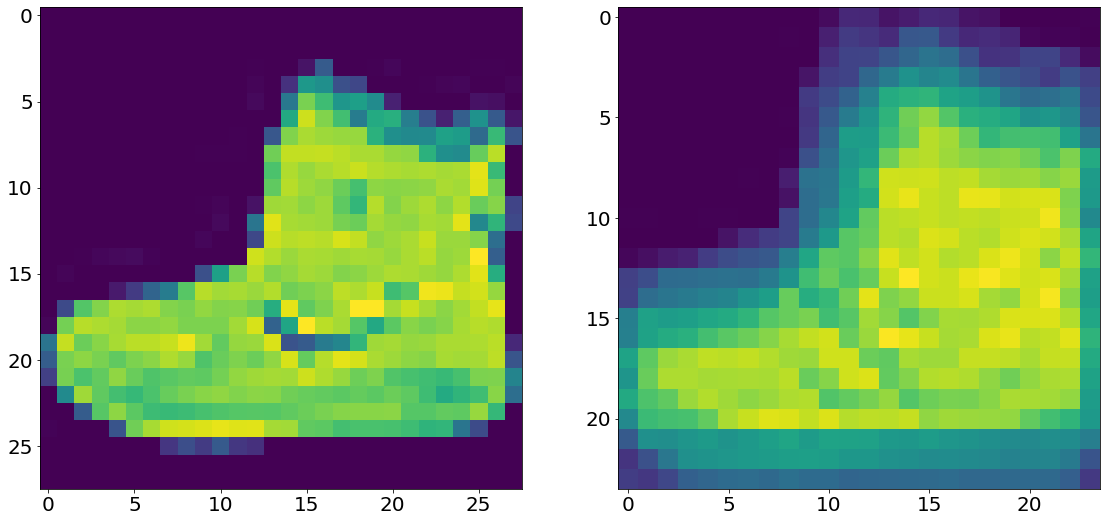

In [25]:
image = FMNIST_train[0][0][0]
dilated_image = dilation(image).view([24,24])

fig, gs = plt.figure(figsize=(19,10)), gridspec.GridSpec(1, 2)

images = [image, dilated_image]

ax = []

for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(images[i]))

plt.show()

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = TeacherModel(input_dim=576).to(device)

_ = Teacher.train()
train_teacher(Teacher, fmnist_big, FMNIST_test, phi=lambda x: dilation(x))

_ = Student.train()
list_of_test_acc_dil, list_of_test_losses_dil, _, _ =\
                        distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher, phi=lambda x: dilation(x))

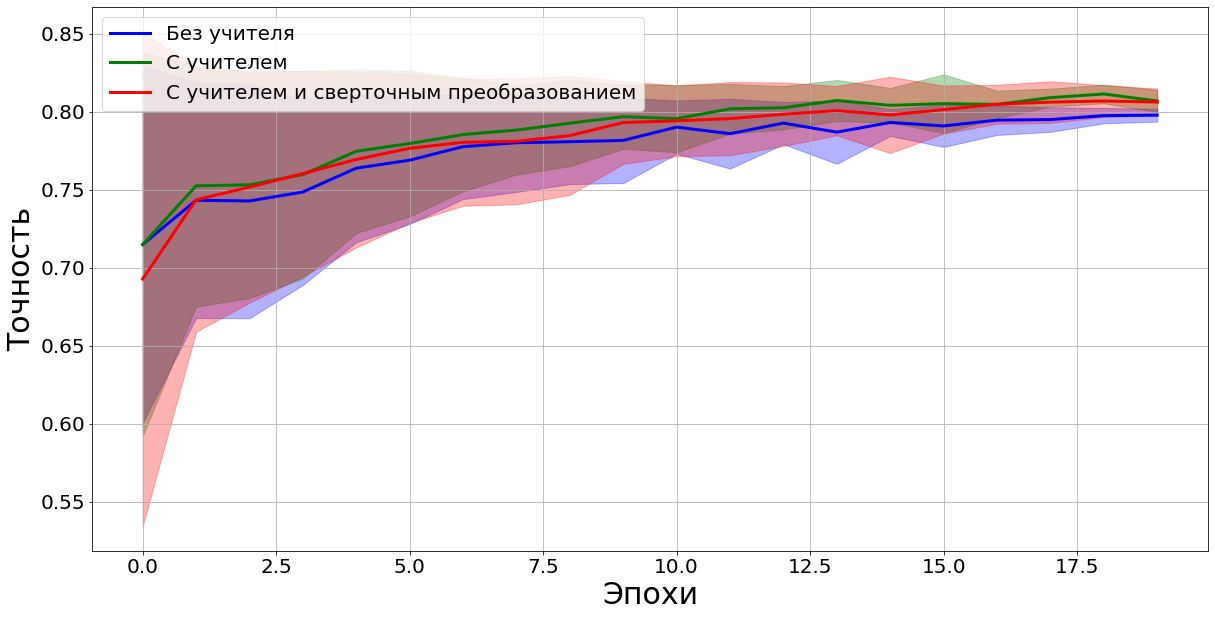

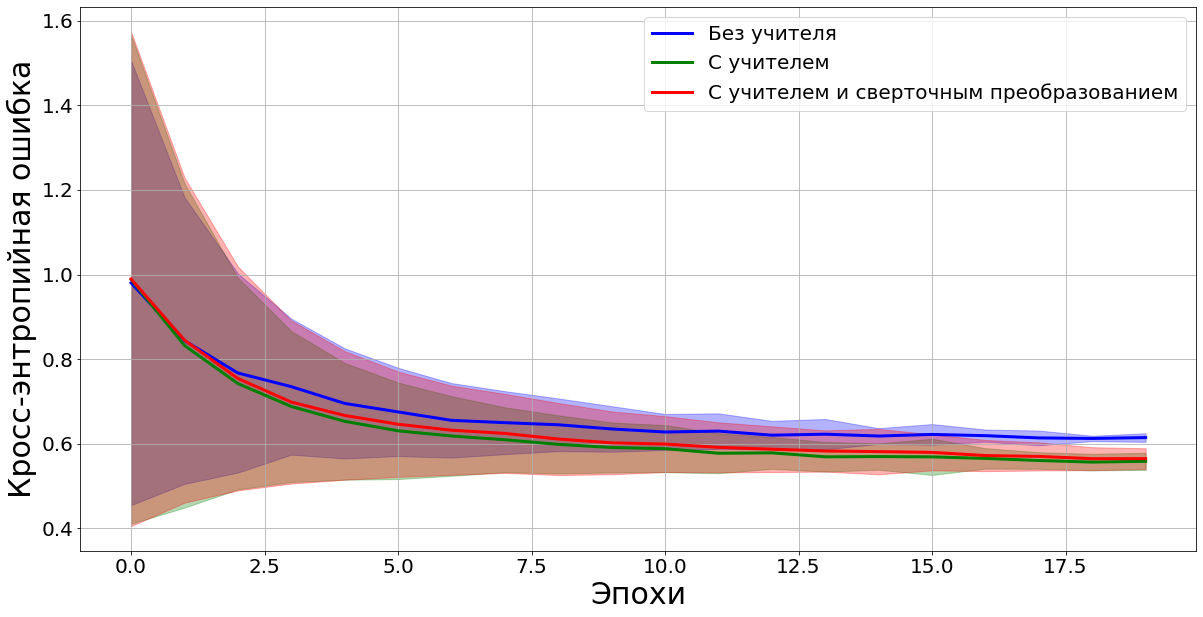

In [28]:
labels = ['Без учителя', 'С учителем', 'С учителем и сверточным преобразованием']

makeplots([list_of_test_acc, list_of_test_acc_dist, list_of_test_acc_dil],
          [list_of_test_losses, list_of_test_losses_dist, list_of_test_losses_dil],
          labels)

In [29]:
print('Accuracy of student with dilated teacher={}+-{}'.format(round(np.array(list_of_test_acc_dil).mean(0)[-1],3),
                                                       round(np.array(list_of_test_acc_dil).std(0)[-1],3)))
print('Loss of student with dilated teacher={}+-{}'.format(round(np.array(list_of_test_losses_dil).mean(0)[-1],3),
                                                   round(np.array(list_of_test_losses_dil).std(0)[-1],3)))

Accuracy of student with dilated teacher=0.806+-0.009
Loss of student with dilated teacher=0.565+-0.025


# Отрисовка изменения 

In [ ]:
Autoencoder = VAE(2, 28*28)
Autoencoder.to(device)

optimizer = torch.optim.Adam

trainer(count_of_epoch=20, 
        batch_size=64, 
        dataset=FashionDigit,
        model=Autoencoder, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001)

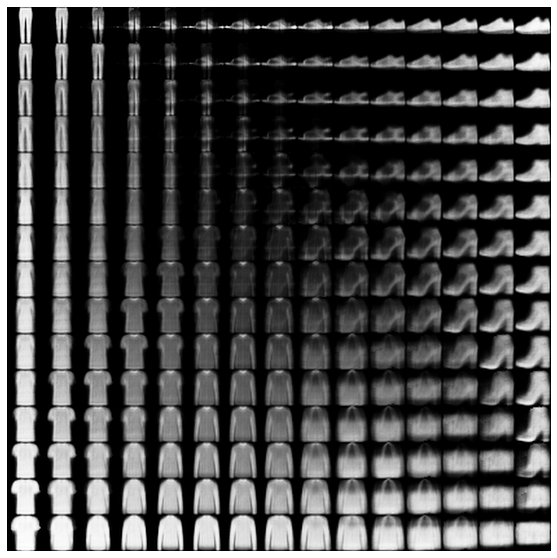

In [36]:
figure = draw_samples_grid_vae(Autoencoder, dataset='fashion')

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', interpolation='lanczos')
plt.axis('off')
plt.show()

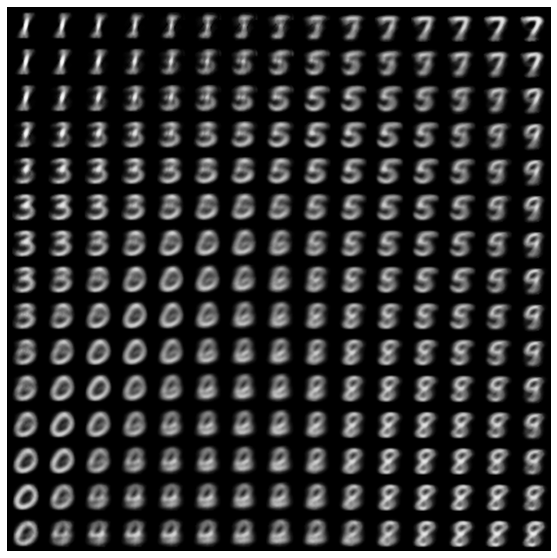

In [37]:
figure = draw_samples_grid_vae(Autoencoder, dataset='digits')

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', interpolation='lanczos')
plt.axis('off')
plt.show()

# $\varphi$=VAE

In [ ]:
Autoencoder = VAE(64, 28*28)
Autoencoder.to(device)

optimizer = torch.optim.Adam

trainer(count_of_epoch=50, 
        batch_size=64, 
        dataset=FashionDigit,
        model=Autoencoder, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001)

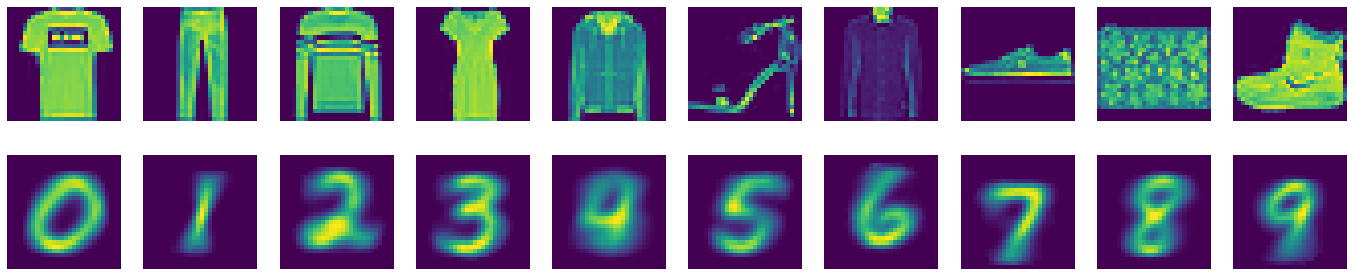

In [46]:
indices = [1,16,5,20,28,8,33,14,23,0]

fmnist_images = []
for i in indices:
    fmnist_images.append(FMNIST_train[i][0])

mnist_images = []
for im in fmnist_images:
    a = im.view([1,784])
    b = fmnist_to_mnist(Autoencoder, a).view([28,28])
    mnist_images.append(b.cpu().detach().numpy())    

fig, gs = plt.figure(figsize=(24,5)), gridspec.GridSpec(2, 10)

ax = []

for i in range(10):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(fmnist_images[i].view([28,28])))
    ax[i].axis('off')

for i in range(10):
    ax.append(fig.add_subplot(gs[i+10]))
    ax[i+10].imshow(np.array(mnist_images[i]))
    ax[i+10].axis('off')

plt.show()

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = TeacherModel().to(device)

_ = Teacher.train()
train_teacher(Teacher, mnist_big, MNIST_test)

_ = Student.train()
list_of_test_acc_mnist, list_of_test_losses_mnist, _, _ =\
                distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher, phi=lambda x: fmnist_to_mnist(Autoencoder, x))

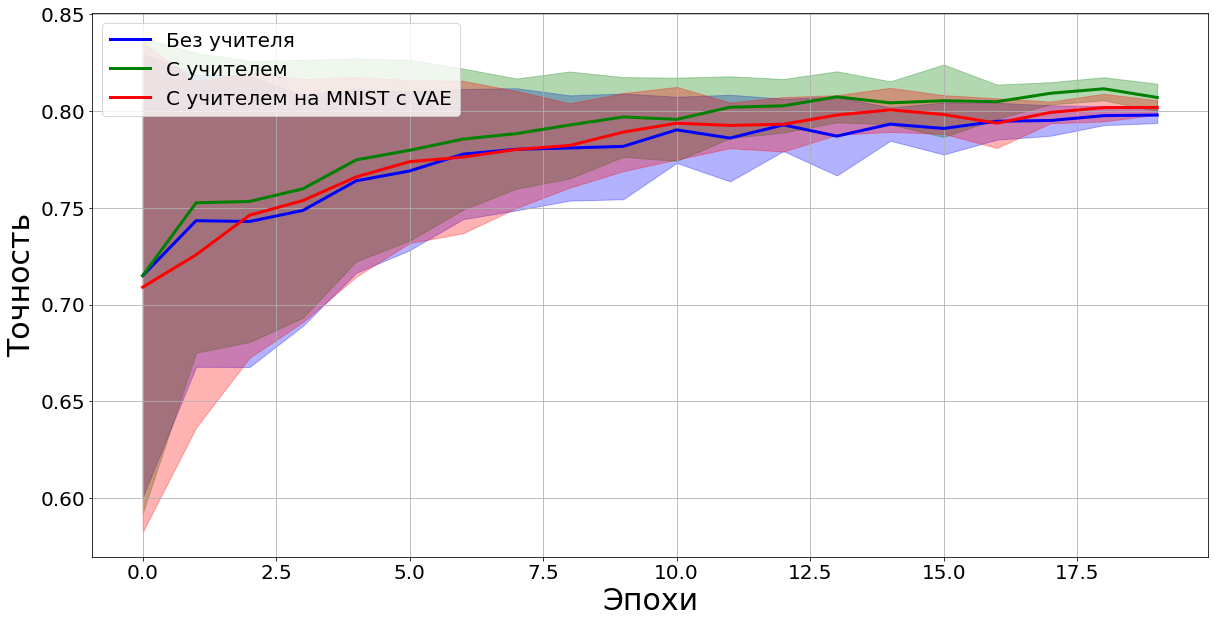

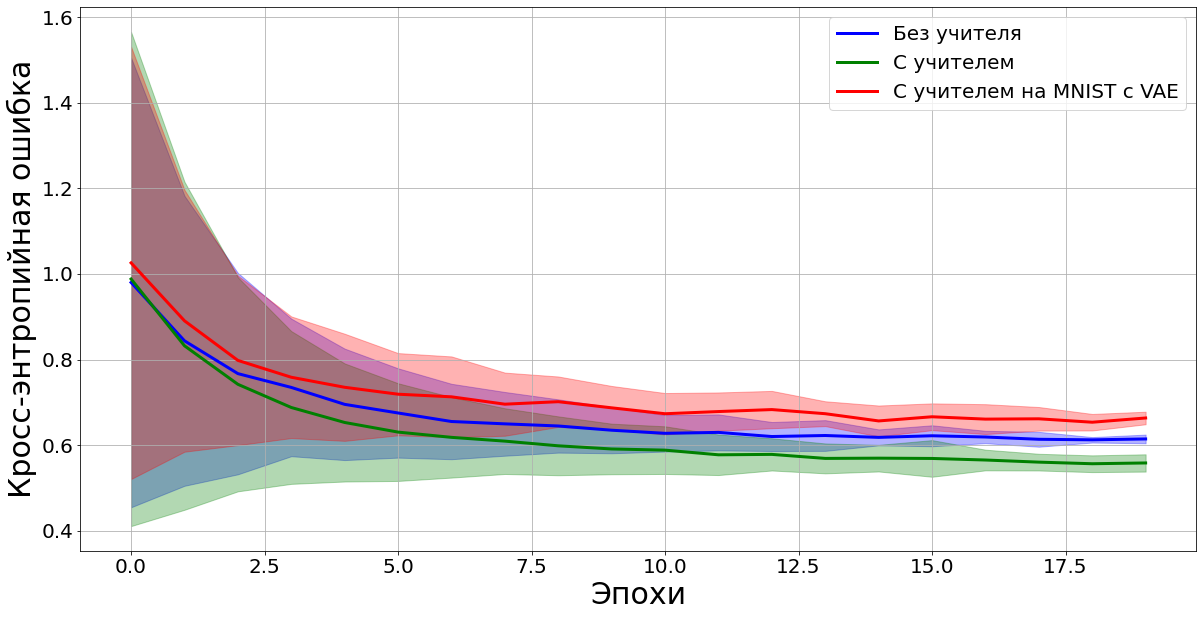

In [48]:
labels = ['Без учителя', 'С учителем', 'С учителем на MNIST с VAE']

makeplots([list_of_test_acc, list_of_test_acc_dist, list_of_test_acc_mnist],
          [list_of_test_losses, list_of_test_losses_dist, list_of_test_losses_mnist],
          labels)

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = TeacherModel().to(device)

_ = Teacher.train()
train_teacher(Teacher, mnist_big, MNIST_test)

_ = Student.train()
list_of_test_acc_mnist_no_vae, list_of_test_losses_mnist_no_vae, _, _ =\
                                distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher)

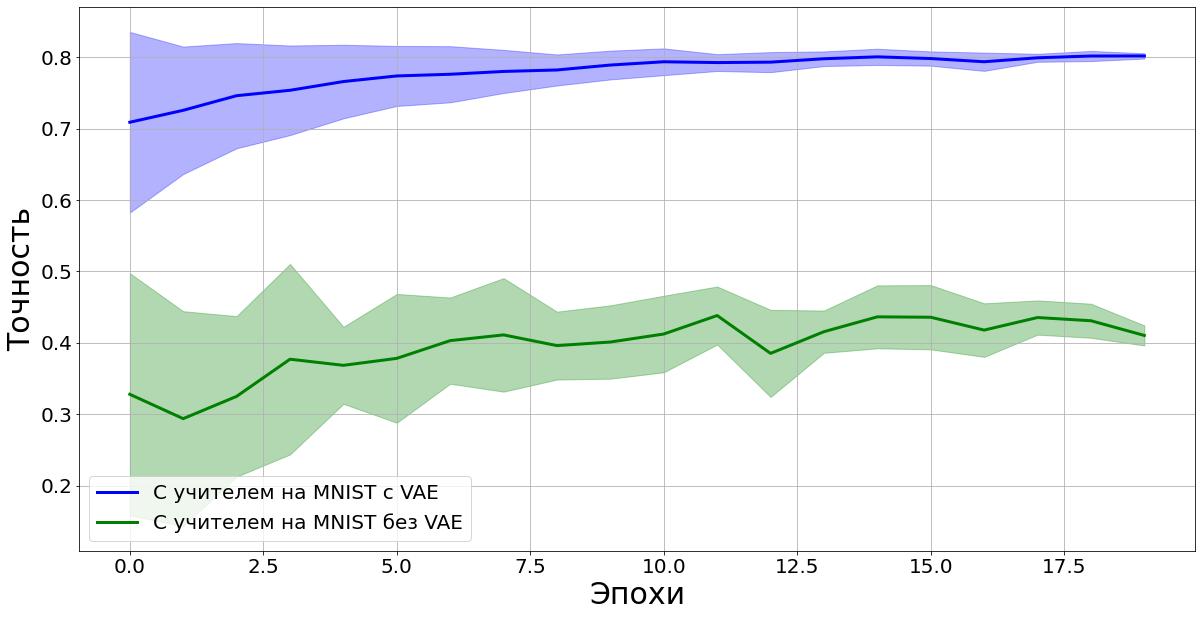

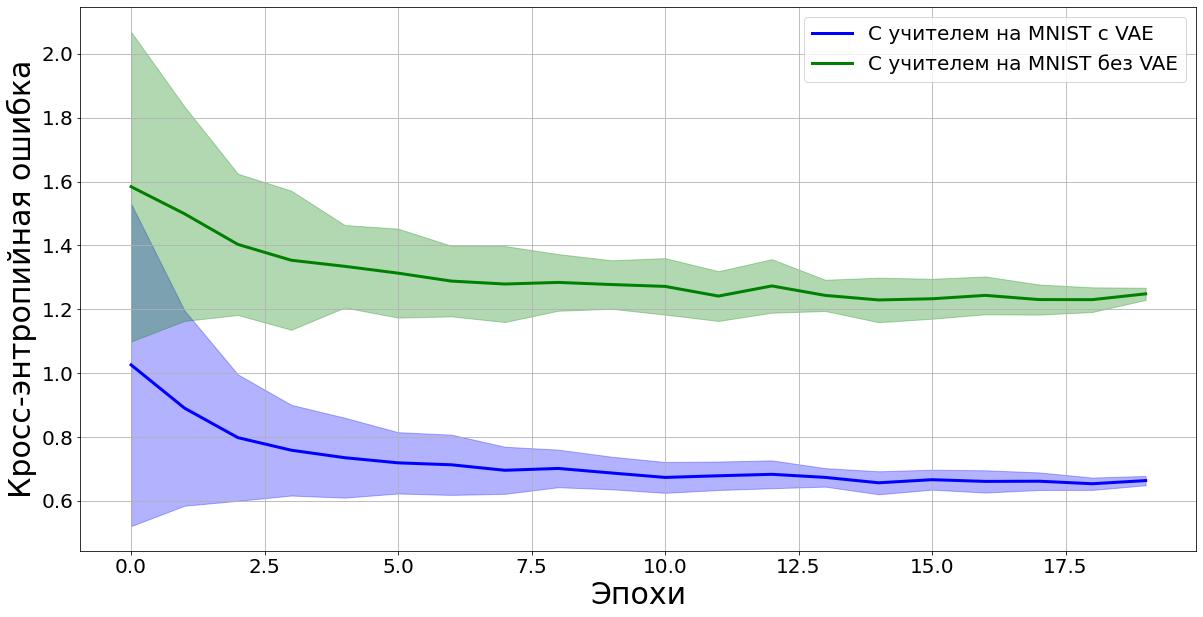

In [53]:
labels = ['С учителем на MNIST с VAE', 'С учителем на MNIST без VAE']

makeplots([list_of_test_acc_mnist, list_of_test_acc_mnist_no_vae],
          [list_of_test_losses_mnist, list_of_test_losses_mnist_no_vae],
          labels)

In [54]:
print('Accuracy of student with teacher on MNIST with VAE={}+-{}'.format(round(np.array(list_of_test_acc_mnist).mean(0)[-1],3),
                                                                         round(np.array(list_of_test_acc_mnist).std(0)[-1],3)))
print('Loss of student with teacher on MNIST with VAE={}+-{}'.format(round(np.array(list_of_test_losses_mnist).mean(0)[-1],3),
                                                                     round(np.array(list_of_test_losses_mnist).std(0)[-1],3)))
print('Accuracy of student with teacher on MNIST w/o VAE={}+-{}'.format(round(np.array(list_of_test_acc_mnist_no_vae).mean(0)[-1],3),
                                                                        round(np.array(list_of_test_acc_mnist_no_vae).std(0)[-1],3)))
print('Loss of student with teacher on MNIST w/o VAE={}+-{}'.format(round(np.array(list_of_test_losses_mnist_no_vae).mean(0)[-1],3),
                                                                round(np.array(list_of_test_losses_mnist_no_vae).std(0)[-1],3)))

Accuracy of student with teacher on MNIST with VAE=0.802+-0.004
Loss of student with teacher on MNIST with VAE=0.664+-0.015
Accuracy of student with teacher on MNIST w/o VAE=0.41+-0.014
Loss of student with teacher on MNIST w/o VAE=1.248+-0.019


# Синтетически расширенная сгенерированная выборка

In [55]:
GMNIST_train, GMNIST_test = GeneratedMNIST(fmnist_small, Autoencoder)

In [56]:
gmnist_big, gmnist_small = torch.utils.data.random_split(GMNIST_train, [59000, 1000], generator=torch.Generator().manual_seed(42))

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = TeacherModel().to(device)

_ = Teacher.train()
train_teacher(Teacher, gmnist_big, GMNIST_test)

_ = Student.train()
list_of_test_acc_ext_mnist, list_of_test_losses_ext_mnist, _, _ =\
                distillation_train(Student, fmnist_small, FMNIST_test, teacher=Teacher, phi=lambda x: fmnist_to_mnist(Autoencoder, x))

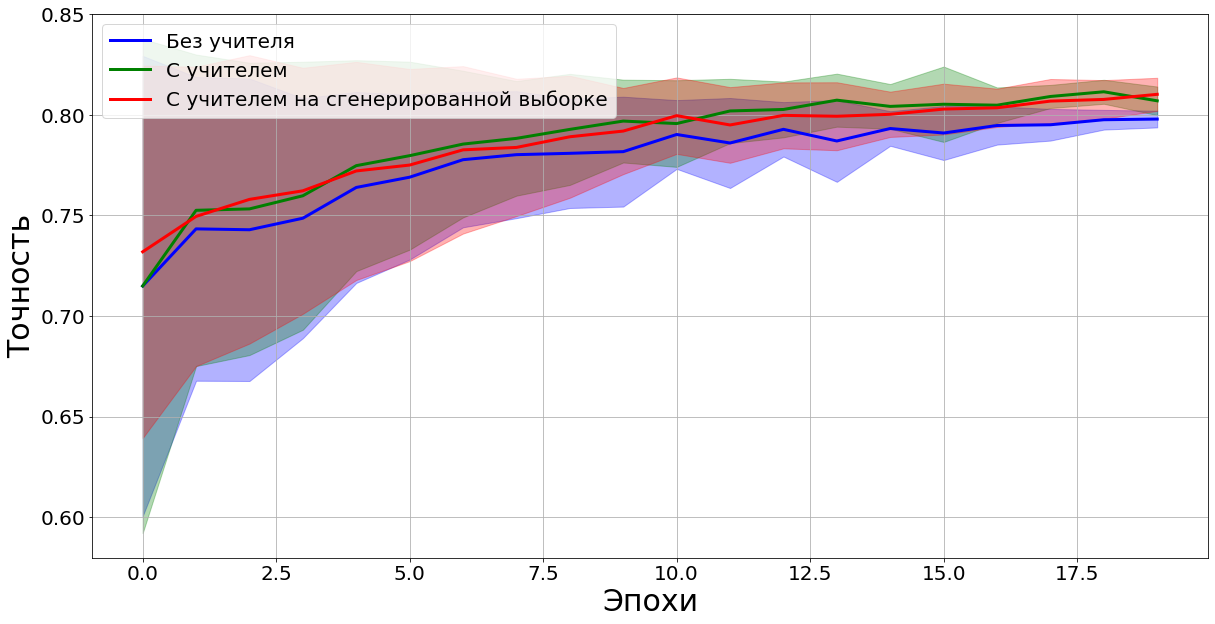

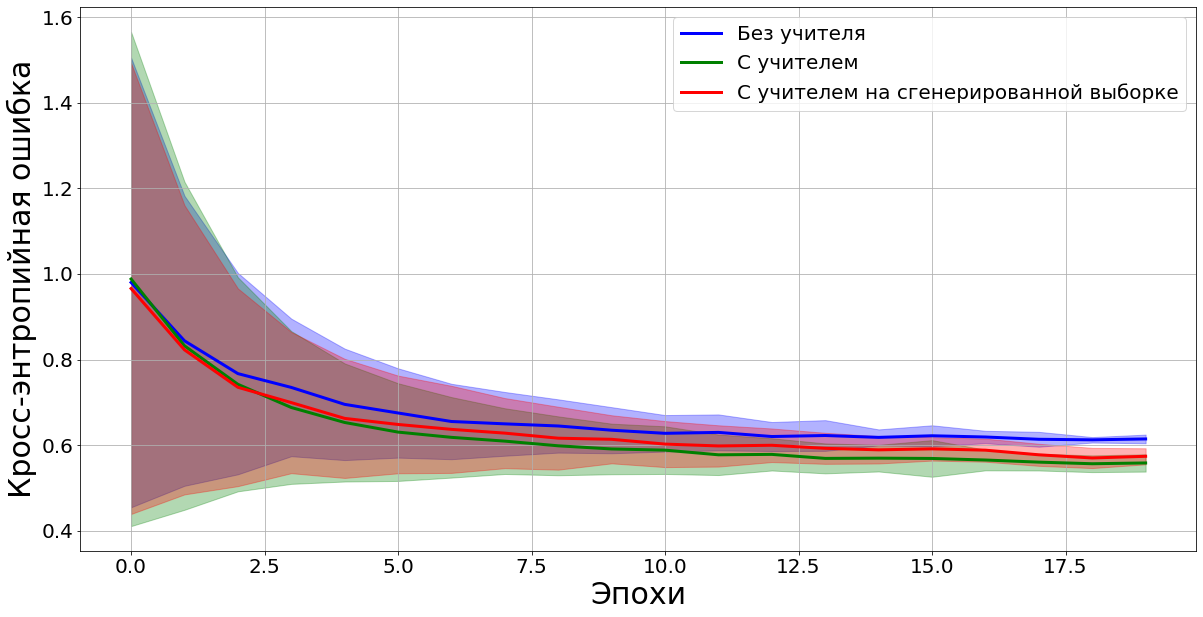

In [59]:
labels = ['Без учителя', 'С учителем', 'С учителем на сгенерированной выборке']

makeplots([list_of_test_acc, list_of_test_acc_dist, list_of_test_acc_ext_mnist],
          [list_of_test_losses, list_of_test_losses_dist, list_of_test_losses_ext_mnist],
          labels)

In [60]:
print('Accuracy of student with teacher on synthetic extended MNIST={}+-{}'.format(round(np.array(list_of_test_acc_ext_mnist).mean(0)[-1],3),
                                                                                   round(np.array(list_of_test_acc_ext_mnist).std(0)[-1],3)))
print('Loss of student with teacher on synthetic extended={}+-{}'.format(round(np.array(list_of_test_losses_ext_mnist).mean(0)[-1],3),
                                                                         round(np.array(list_of_test_losses_ext_mnist).std(0)[-1],3)))

Accuracy of student with teacher on synthetic extended MNIST=0.81+-0.008
Loss of student with teacher on synthetic extended=0.574+-0.019
